# Synchornization in complete networks of neurons
Here is the equation of neurons potentails dynamics:
$$
\dot{v_i}=a_i - v_i - \frac{g}{N} \sum_{n|t_n<t} S_{i,l(n)} \delta(t - t_n - t_d) 
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constants and parameters:

In [2]:
num_neurons = 1000
g = 5
random_input_span = (1.2,2.8)

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

potentail_arr = np.zeros(num_neurons,dtype = float)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )

### Useful functions:

In [4]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0

## Solving the differential equation

In [5]:
for i in tqdm( range(total_steps) ):
    potentail_arr = potentail_arr + (random_input - potentail_arr)*time_step - (g/num_neurons)*retarded_spikes_record(i)
    spiking_records[i] = potentail_arr > 1
    potentail_arr = potentail_arr - 1 * spiking_records[i]
#     reset_func = lambda v: v-1 if v>1 else v
#     vfunc = np.vectorize(reset_func)
#     potentail_arr = vfunc(potentail_arr)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 23116.09it/s]


(array([ 86.,  78., 112., 156., 121.,  88.,  98., 145.,  69.,  47.]),
 array([-0.25081172, -0.13834034, -0.02586897,  0.08660241,  0.19907378,
         0.31154516,  0.42401653,  0.53648791,  0.64895928,  0.76143066,
         0.87390203]),
 <a list of 10 Patch objects>)

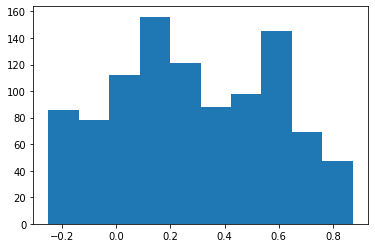

In [6]:
plt.hist(potentail_arr)

# Measuring E (effective field):
we can measure if the total network is synchronized. let's define E as following:

$$
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
$$

To do so, we define $M$ as $M = \dot{E} + \alpha E$. As a result we wil have the following systems of equation:
\begin{equation}
    \begin{cases}
      \dot{E} = M - \alpha E\\
      \dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
    \end{cases}\,.
\end{equation}


In [7]:
alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

In [8]:
for i in tqdm(range(0,total_steps-1)):
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:03<00:00, 29329.88it/s]


Text(0.5, 1.0, 'E')

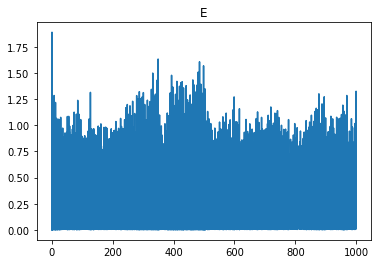

In [9]:
plt.plot(time_span,e_arr)
plt.title('E')

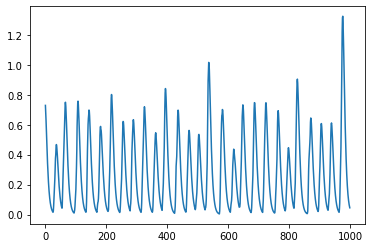

In [10]:
plt.plot(e_arr[-1000:])

In [11]:
sigma = np.std( e_arr )
sigma

0.24150314713212956

# Rasterplot

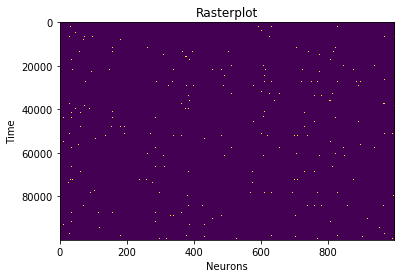

In [12]:
plt.imshow( spiking_records,aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig('raster_plot_N{}.png'.format(num_neurons))

In [13]:
spiking_records

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

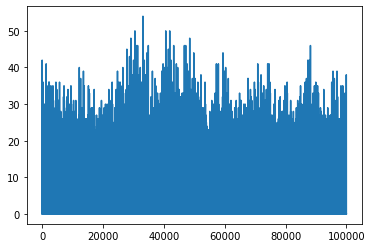

In [14]:
plt.plot(np.sum( spiking_records, axis = 1))